In [1]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np
from shapely.geometry import LineString

In [34]:
df_grid = pd.read_excel('./grid.xlsx', index_col=0)
df_substations = pd.read_excel('./substations.xlsx', index_col=0)
df_powerplants = pd.read_excel('../flow_based_domain/plants.xlsx', index_col=0)

In [48]:
for index, row in df_powerplants.iterrows():
    if row['type'] == 'coal_gas':
        df_powerplants.loc[index, 'type'] = 'natural_gas'
        
df_powerplants = df_powerplants[df_powerplants.type != 'marine']

In [72]:
df_powerplants

,name,eic,type,zone,installed_capacity,lat,lon,node,construction_year
0,GDK-Mellach,14W-WGM-KW-----J,natural_gas,AT,838.0,46.911700,15.488300,1091,0
1,Ottensheim-Wilhering,14W-BOW-KW-----9,hydro_run_of_river,AT,179.0,48.316500,14.151057,1280,1974
2,FHKW Linz Mitte,14WLSG-MITTE---U,natural_gas,AT,216.8,48.299219,14.322935,690,1970
3,Kraftwerk Theiß,14W-KW-THE-EVN-7,natural_gas,AT,485.0,48.394861,15.710147,1064,2000
4,FHKW Linz Süd,14WLSG-1SUED---5,natural_gas,AT,158.0,48.267893,14.346898,690,1993
...,...,...,...,...,...,...,...,...,...
636,Petrokemija Kutina,NaN,natural_gas,HR,35.0,45.471290,16.792320,1171,0
637,Dubrovnik,NaN,hydro_reservoir,HR,216.0,42.603001,18.235001,187,0
638,Fuzine,NaN,hydro_pumped_storage,HR,5.7,45.304985,14.714837,412,0
639,He Rijeka,NaN,hydro_run_of_river,HR,36.8,45.334999,14.452000,417,0


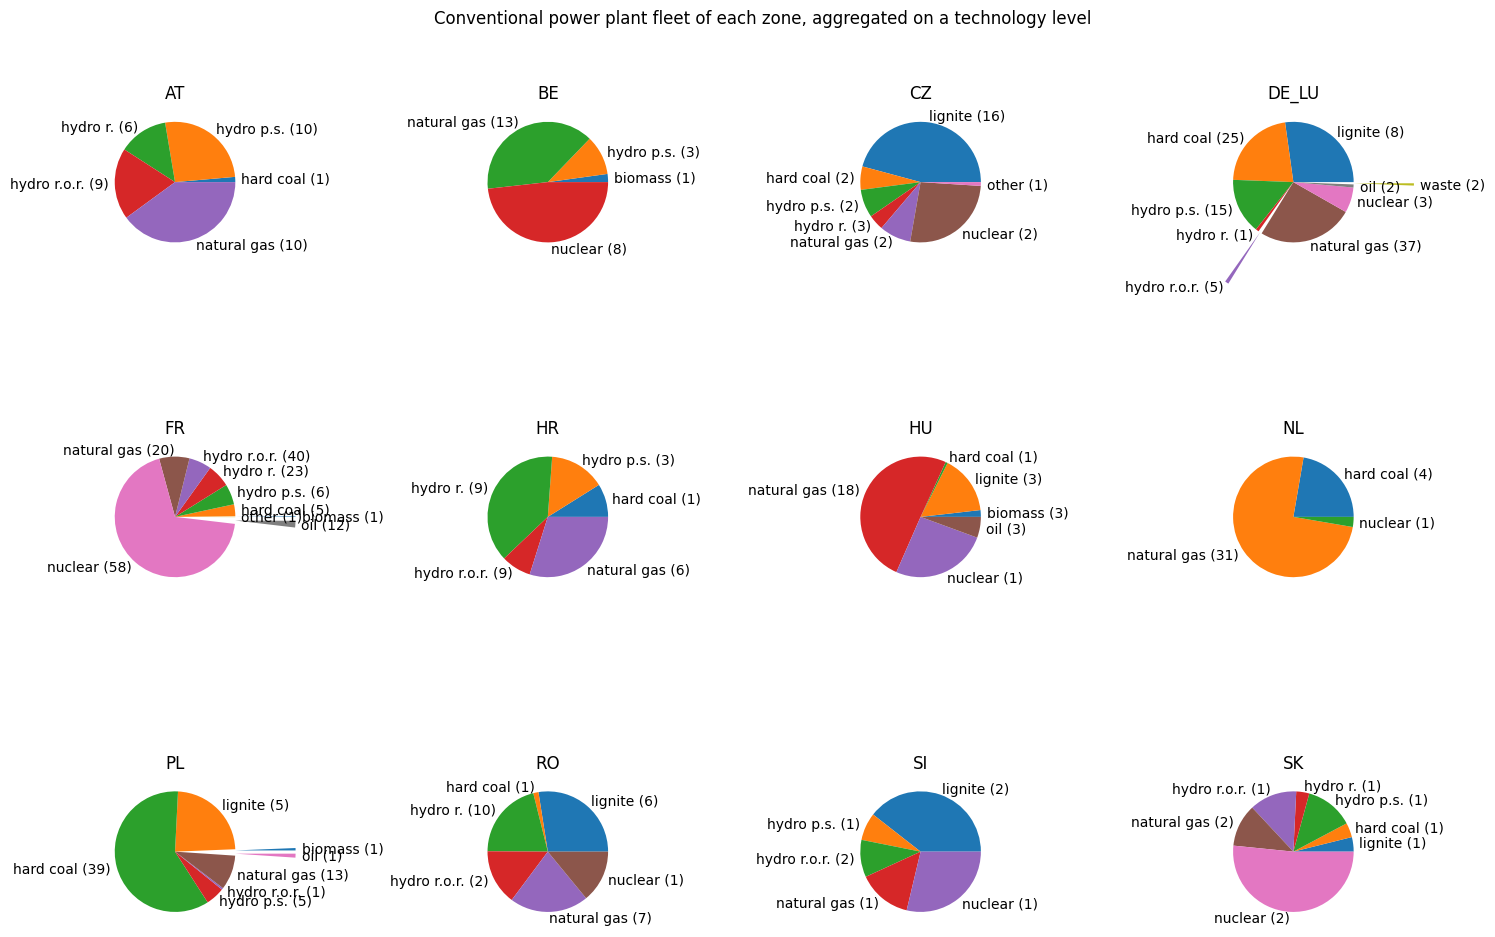

In [71]:
def explode_function(zone):
    tech_list = list(df_powerplants[df_powerplants.zone == zone].groupby('type').count().index)
    arr = np.zeros(len(tech_list))
    if zone in ['FR', 'PL']:
        arr[tech_list.index('oil')] = 1
        arr[tech_list.index('biomass')] = 1
    if zone in ['DE_LU']:
        arr[tech_list.index('hydro_run_of_river')] = 1
        arr[tech_list.index('waste')] = 1
    
    return arr

ppm_types = ['nuclear', 'hard coal', 'natural gas', 'hydro r.', 'hydro p.s.', 'hydro r.o.r.', 'lignite', 'oil', 'biomass', 'other', 'wind', 'solar', 'waste']
ppm_type_map = ['nuclear', 'hard_coal', 'natural_gas', 'hydro_reservoir', 'hydro_pumped_storage', 'hydro_run_of_river', 'brown_coal', 'oil', 'biomass', 'other', 'wind', 'solar', 'waste']

zones = ['AT', 'BE', 'CZ', 'DE_LU', 'FR', 'HR', 'HU', 'NL', 'PL', 'RO', 'SI', 'SK']
fig, axs = plt.subplots(3, 4, sharey=True, sharex=True, figsize=(15, 10))
zone_axs = [
    axs[0, 0], axs[0, 1], axs[0, 2], axs[0, 3],
    axs[1, 0], axs[1, 1], axs[1, 2], axs[1, 3],
    axs[2, 0], axs[2, 1], axs[2, 2], axs[2, 3],
]

for index, zone in enumerate(zones):
    zone_axs[index].pie(df_powerplants[df_powerplants.zone == zone].groupby('type').sum(numeric_only=True)['installed_capacity'], 
                        labels=[
                            "{0} ({1})".format(ppm_types[ppm_type_map.index(tech)], df_powerplants[df_powerplants.zone == zone].groupby('type').count().loc[tech, 'name']) 
                            for tech in df_powerplants[df_powerplants.zone == zone].groupby('type').count().index], 
                        explode=explode_function(zone)
                        #colors=[colors[i] for i in active_idx]
    )
    zone_axs[index].set_title(zone)
    
#for ax in axs.flat:
    #ax.set(xlabel='MRE [-]', ylabel='Occurence [-]')

for ax in axs.flat:
    ax.label_outer()

fig.suptitle('Conventional power plant fleet of each zone, aggregated on a technology level')
plt.tight_layout()

In [3]:
nodes_to_remove = [
    594, 423, 568, 1127, 1011, 327, 585, 14, 1209, 363, 215,
    1012, 661, 764, 838, 1272, 254, 1055, 755, 589, 116, 967,
    863, 1023, 11, 1068, 282
]

df_grid_cleaned = df_grid[~df_grid.substation_1.isin(nodes_to_remove) & ~df_grid.substation_2.isin(nodes_to_remove)]

In [24]:
edgelist = []
edge_zones = []
for index, row in df_grid_cleaned.iterrows():
    edgelist.append((row.substation_1, row.substation_2))
    edge_zones.append((list(df_grid.zone.unique()).index(row.zone) + 1)/12)

Grid = nx.Graph(edgelist)

In [33]:
for comp in nx.connected_components(Grid):
    print(comp)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 216, 217, 218, 219, 220, 221, 222, 223, 224, 22

ValueError: Invalid RGBA argument: 0.08333333333333333

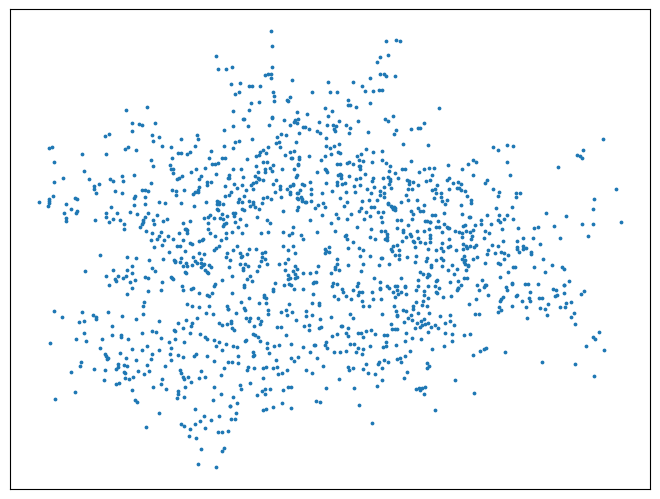

In [28]:
nx.draw(Grid, edge_cmap=plt.get_cmap('viridis'), edge_color=set(edge_zones), node_size=3)

In [34]:
df_grid_cleaned.to_excel('./grid_connected.xlsx')

In [ ]:
df_substations = pd.read_excel('./substations.xlsx', index_col=0)